<h1 style="text-align: center;">DeepONet</h1>

## DeepONet for ODE

In this presentation, we will explore DeepONet, as introduced in the paper Learning Nonlinear Operators via DeepONet Based on the Universal Approximation Theorem of Operators by Lu Lu, Pengzhan Jin, Guofei Pang, Zhongqiang Zhang, and George Em Karniadakis. To ensure clarity and respect for the original work, we will first consider the antiderivative operator as a means of solving a linear ordinary differential equation (ODE)

$$\frac{\partial s(x)}{\partial x} = u(x), \quad s(0) = 0.$$
Then we have
$$s(x) = \int_0^{x}u(\tau)d\tau$$

We arrange the data as the form of following

<img src="deeponet.png" alt="My Image" width="800"/>
It is akin to providing the neural network with the structure of the function (parameter)  $u(x)$ defined by the given grid points  ($x$ values). For each variable $x_i$,  the network produces the corresponding value  $s_i$.

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from gstools import SRF, Exponential, Matern,Gaussian
from gstools.random import MasterRNG
from scipy import integrate
import time
from torch.utils.data import DataLoader, TensorDataset,Dataset
import torch.nn.functional as F
import torch.optim as optim

Below, we define no_points as the number of points for the variable $x$, and no_function as the number of functions $u$. This means there are a total of no_function functions $u$ and for each $u$, no_points are selected to represent and train during the subsequent process. We also visulize a couple of $u(x)$ below. This can be interpreted as repeatedly informing the branch neural network about the structure of $u$, while providing the trunk neural network with the input variable to determine the corresponding output.

In [89]:
no_points = 100                       
no_ufunction = 110

In [90]:
x = np.linspace(0, 1, no_points)

In [91]:
seed = MasterRNG(45)
def generate_function(x, model_type='Gaussian'):

    if model_type == 'Gaussian':
        model = Gaussian(dim=1, var=1, len_scale=0.2)
    elif model_type == 'Exponential':
        model = Exponential(dim=1, var=1, len_scale=0.2)
    elif model_type == 'Matern':
        model = Matern(dim=1, var=1, len_scale=0.2, nu=1.5)

    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [92]:
Ufunction = np.zeros((no_points,no_ufunction))
for i in range(no_ufunction):
    Ufunction[:,i] = generate_function(x)

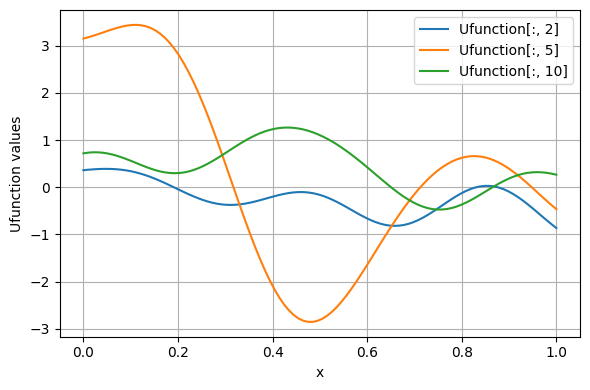

In [93]:
no_ufunction_values = [2, 5, 10]  # Different values for no_ufunction

plt.figure(figsize=(6, 4))
for  no_u in no_ufunction_values:
     
    plt.plot(x, Ufunction[:, no_u], label=f'Ufunction[:, {no_u}]')
    
    plt.xlabel('x')
    plt.ylabel('Ufunction values')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

We calculate the antiderivative of the function $u(x)$, which can serve as the output for the neural network. We correspondly visulize the antiderivative of the above selected $u(x)$.

In [94]:
def antiderivative(ufunction):
    Sfunction = np.zeros_like(ufunction)
    Sfunction[0]=0
    for i in range(1, len(ufunction)):
        Sfunction[i]= integrate.simpson(ufunction[:i+1],x=x[:i+1])
    return Sfunction

In [95]:
Sfunction = np.zeros((no_points,no_ufunction))
for i in range(no_ufunction):
    Sfunction[:,i] = antiderivative(Ufunction[:,i])

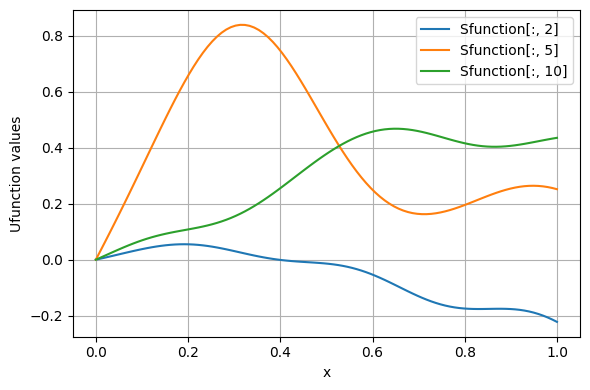

In [96]:
no_ufunction_values = [2, 5, 10]  # Different values for no_ufunction

plt.figure(figsize=(6, 4))
for  no_u in no_ufunction_values:
     
    plt.plot(x, Sfunction[:, no_u], label=f'Sfunction[:, {no_u}]')
    
    plt.xlabel('x')
    plt.ylabel('Ufunction values')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In the following, the input and output data are organized as illustrated in the figure from the first section.

In [97]:
def arrange_Ufunction_x_S(no_points, no_ufunction, x, Ufunction, G_antideriv4Uf):
    # Create index arrays for Uf_G and G_G
    Uf_s = np.tile(Ufunction.T, (1, no_points)).reshape(no_points * no_ufunction, no_points)
    x_s = np.repeat(x.reshape(no_points, 1), no_ufunction, axis=1).T.flatten()[:, np.newaxis]
    S_s = Sfunction.T.flatten()[:, np.newaxis]

    return Uf_s, x_s, S_s

In [98]:
Uf_s, x_s, S_s = arrange_Ufunction_x_S(no_points, no_ufunction, x, Ufunction, Sfunction)

In [99]:
print(Uf_s.shape)
print(x_s.shape)
print(S_s.shape)

(11000, 100)
(11000, 1)
(11000, 1)


In [109]:
def data_split_loader(batch_size, no_points, no_ufunction, x, Ufunction, Sfunction, ratio=0.7):
    # Assuming `arrange_Ufunction_x_S` is defined elsewhere and works the same
    Uf_s, x_s, S_s = arrange_Ufunction_x_S(no_points, no_ufunction, x, Ufunction, Sfunction)

    # # Split the data into train and test sets
    # train_size = int(len(Uf_s) * ratio)
    # Uf_s_train, x_s_train, S_s_train = Uf_s[:train_size], x_s[:train_size], S_s[:train_size]
    # Uf_s_test, x_s_test, S_s_test = Uf_s[train_size:], x_s[train_size:], S_s[train_size:]

    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Shuffle the indices
    indices = np.random.permutation(len(Uf_s))
    
    # Calculate the training size
    train_size = int(len(Uf_s) * ratio)
    
    # Split the indices for training and testing
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    # Use the indices to create train and test sets
    Uf_s_train, x_s_train, S_s_train = Uf_s[train_indices], x_s[train_indices], S_s[train_indices]
    Uf_s_test, x_s_test, S_s_test = Uf_s[test_indices], x_s[test_indices], S_s[test_indices]

    # Convert to PyTorch tensors
    Uf_s_train = torch.tensor(Uf_s_train, dtype=torch.float32)
    x_s_train = torch.tensor(x_s_train, dtype=torch.float32)
    S_s_train = torch.tensor(S_s_train, dtype=torch.float32)

    Uf_s_test = torch.tensor(Uf_s_test, dtype=torch.float32)
    x_s_test = torch.tensor(x_s_test, dtype=torch.float32)
    S_s_test = torch.tensor(S_s_test, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(Uf_s_train, x_s_train, S_s_train)
    test_dataset = TensorDataset(Uf_s_test, x_s_test, S_s_test)

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader

In [110]:
batch_size = 32
train_data, test_data = data_split_loader(batch_size,no_points, no_ufunction, x, Ufunction, Sfunction,ratio=0.7)

Process branch input         Process trunk input        Perform the element-wise multiplication and sum along the feature dimension  this output is used to compare with the exact solution s Add a new dimension to matach the dimsion with S_s

In [111]:
class DeepONet(nn.Module):
    def __init__(self, neurons=40, branch_input=10, trunk_input=1, output_neurons=20):
        super(DeepONet, self).__init__()
        self.branch_input = branch_input
        self.trunk_input = trunk_input
        self.output_neurons = output_neurons
        self.neurons = neurons

        self.branch = self.branch_network()
        self.trunk = self.trunk_network()

    def branch_network(self):
        return nn.Sequential(
            nn.Linear(self.branch_input, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )

    def trunk_network(self):
        return nn.Sequential(
            nn.Linear(self.trunk_input, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )

    def forward(self, x1, x2):
        x1 = self.branch(x1)  # Process branch input
        x2 = self.trunk(x2)  # Process trunk input
        # Perform the element-wise multiplication and sum along the feature dimension
        x = torch.sum(x1 * x2, dim=1)  # this output is used to compare with the exact solution s
         
        x = x.unsqueeze(1)  # Add a new dimension to matach the dimsion with S_s
         
        return x

In [112]:
model = DeepONet(neurons=40, branch_input= no_points, trunk_input=1,output_neurons=20)

In [113]:
print(model)

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
)


In [114]:
def loss_function(y_pred, y):
    return torch.mean((y_pred - y) ** 2)

In [115]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [116]:
train_losses = []
epochs = 100

# Measure training time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    l_total = 0.0

    for Uf_batch, x_batch, G_batch in train_data:
        # Move data to device (if using GPU)
        Uf_batch = Uf_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        x_batch = x_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        G_batch = G_batch.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass
        y_pred = model(Uf_batch, x_batch)
        loss = loss_function(y_pred, G_batch)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

        l_total += loss.item()  # Accumulate the loss

    l_total /= len(train_data)  # Average loss for the epoch
    train_losses.append(l_total)

    # Print progress every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}/{epochs}, Loss: {l_total}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch: 0/100, Loss: 0.016132964246376915
Epoch: 20/100, Loss: 0.0006504316532987274
Epoch: 40/100, Loss: 0.0003938254945200416
Epoch: 60/100, Loss: 0.0002953441807187715
Epoch: 80/100, Loss: 0.0001956326663147521
Training time: 242.81 seconds


In [117]:
# Evaluate on test data
model.eval()  # Set the model to evaluation mode
l_total_test = 0.0
with torch.no_grad():  # Disable gradient computation for testing
    for Uf_batch, x_batch, G_batch in test_data:
        # Move data to device (if using GPU)
        Uf_batch = Uf_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        x_batch = x_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        G_batch = G_batch.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass
        y_pred = model(Uf_batch, x_batch)
        loss = loss_function(y_pred, G_batch)

        l_total_test += loss.item()  # Accumulate the loss

l_total_test /= len(test_data)  # Average test loss
print(f"Final Test Loss: {l_total_test:.4f}")

Final Test Loss: 0.0002


## DeepONet for 1d heat equation

Similarly, we consider the 1 d heat equation
$$\frac{\partial u(x,t)}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} = 0, \quad u(0,x) = u_{ini}(x).$$
Here the DeepONet for the heat equation is similar as above ODE, the only difference is the input dimension for th trunk net is 2 not 1.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from gstools import SRF,Gaussian, Exponential, Matern
from gstools.random import MasterRNG
from scipy import integrate
from scipy.linalg import solve
import torch.optim as optim
import time
from torch.utils.data import DataLoader, TensorDataset,Dataset
import torch.nn.functional as F

#### Parameter settings

In [2]:
mx = 40  #  number of points in space
mt = 50  #  number of points in time
n = 10   #  number of inital conditions
x_range = 1
y_range = 2

In [3]:
x = np.linspace(0, x_range, mx)
y = np.linspace(0, y_range, mt)

alpha = 0.01

dx = abs(x[0]-x[1])
dt = abs(y[0]-y[1])

r = alpha * dt / dx**2  # Stability factor (for explicit method)
print(r)

0.6208163265306123


In [4]:
seed = MasterRNG(45)
def generate_function(x, model_type='Gaussian'):

    if model_type == 'Gaussian':
        model = Gaussian(dim=1, var=50, len_scale=0.6)
    elif model_type == 'Exponential':
        model = Exponential(dim=1, var=50, len_scale=0.6)
    elif model_type == 'Matern':
        model = Matern(dim=1, var=50, len_scale=0.2, nu=1.5)

    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [5]:
U_in = np.zeros((mx,n))

for nindx in range(n):
    x_values = generate_function(x)
    U_in[:,nindx] = x_values

In [6]:
X, Y = np.meshgrid(y,x)
print(X)
print(Y)

[[0.         0.04081633 0.08163265 ... 1.91836735 1.95918367 2.        ]
 [0.         0.04081633 0.08163265 ... 1.91836735 1.95918367 2.        ]
 [0.         0.04081633 0.08163265 ... 1.91836735 1.95918367 2.        ]
 ...
 [0.         0.04081633 0.08163265 ... 1.91836735 1.95918367 2.        ]
 [0.         0.04081633 0.08163265 ... 1.91836735 1.95918367 2.        ]
 [0.         0.04081633 0.08163265 ... 1.91836735 1.95918367 2.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.02564103 0.02564103 0.02564103 ... 0.02564103 0.02564103 0.02564103]
 [0.05128205 0.05128205 0.05128205 ... 0.05128205 0.05128205 0.05128205]
 ...
 [0.94871795 0.94871795 0.94871795 ... 0.94871795 0.94871795 0.94871795]
 [0.97435897 0.97435897 0.97435897 ... 0.97435897 0.97435897 0.97435897]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [7]:
print(U_in.shape)

(40, 10)


In [8]:
S = np.zeros((mx,mt,n))
#S = U
for t in range(mt):
    S[:,t,:] = U_in #  the initial conditions for different points in x and uinis, this will update later in time domain

print(S[:,0,0])

[ 0.39588062  1.29230929  2.22946714  3.19851283  4.19019273  5.19494608
  6.2030125   7.20454043  8.1896951   9.14876462 10.07226287 10.95102813
 11.77631616 12.53988692 13.23408404 13.8519063  14.38707054 14.83406566
 15.18819736 15.44562342 15.6033796  15.65939615 15.61250518 15.46243921
 15.20982119 14.85614659 14.40375795 13.85581251 13.21624351 12.48971585
 11.68157661 10.79780117  9.84493553  8.83003549  7.76060315  6.64452153
  5.48998759  4.30544435  3.09951259  1.88092242]


#### Numerical Solutions Updated in the Time Domain

In [9]:
A = np.zeros((mx, mx))
for i in range(1, mx-1):
    A[i, i-1] = -r
    A[i, i]   = 1 + 2*r
    A[i, i+1] = -r

# Boundary conditions in matrix form
A[0, 0] = A[-1, -1] = 1

for d in range(n):
    for t in range(0, mt-1):
        b = S[:,t,d]
        # Apply boundary conditions
        b[0] = S[0,t,d]
        b[-1] = S[-1,t,d]
        # Solve the linear system A*u^{n+1} = b
        u = solve(A, b)

        S[:,t+1,d] = u

print(S[:,:,0].shape)

(40, 50)


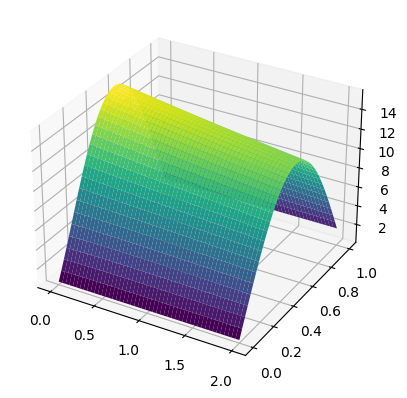

In [10]:

fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
ax.plot_surface(X, Y, S[:,:,0], cmap='viridis')

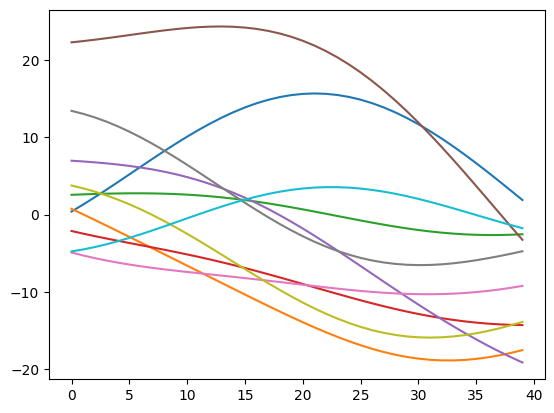

In [11]:
plt.plot(U_in)

In [12]:
x.shape, y.shape, S.shape, U_in.shape

((40,), (50,), (40, 50, 10), (40, 10))

We arrange the data as the form of following
<img src="deeponet_xt.png" alt="My Image" width="800"/>

It is the same as the figure in the first section except that the input in the trunck neural network has two features.

In [13]:
def arrange_data(mx=mx, mt=mt, n=n, U_in=U_in, S=S):
    us = np.zeros((mx*mt*n, mx))
    xs = np.zeros((mx*mt*n, 2))
    ss = np.zeros((mx*mt*n, 1))
    count = 0
    for i in range(n):
        for k in range(mt):
            for j in range(mx):
                us[count,:] = U_in[:,i]
                xs[count] = [x[j],y[k]]
                ss[count] = S[j, k, i]
                count = count+1

    return us, xs, ss

In [14]:
us,xs,ss = arrange_data()

In [15]:
us.shape, xs.shape, ss.shape  # the dimension comes from mx*mt*n

((20000, 40), (20000, 2), (20000, 1))

In [21]:
def data_split_loader(batch_size, mx, mt, n, S, ratio=0.8):
    # Arrange the data (you need to implement this function)
    us, xs, ss = arrange_data(mx, mt, n, U_in, S)

    # Split data into training and testing sets
    # train_size = int(len(us) * ratio)
    # us_train, us_test = us[:train_size], us[train_size:]
    # xs_train, xs_test = xs[:train_size], xs[train_size:]
    # ss_train, ss_test = ss[:train_size], ss[train_size:]

    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Shuffle the indices
    indices = np.random.permutation(len(us))
    
    # Calculate the training size
    train_size = int(len(us) * ratio)
    
    # Split the indices for training and testing
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    # Use the indices to create train and test sets
    us_train, xs_train, ss_train = us[train_indices], xs[train_indices], ss[train_indices]
    us_test, xs_test, ss_test = us[test_indices], xs[test_indices], ss[test_indices]


    # Convert to PyTorch tensors
    us_train = torch.tensor(us_train, dtype=torch.float32)
    xs_train = torch.tensor(xs_train, dtype=torch.float32)
    ss_train = torch.tensor(ss_train, dtype=torch.float32)

    us_test = torch.tensor(us_test, dtype=torch.float32)
    xs_test = torch.tensor(xs_test, dtype=torch.float32)
    ss_test = torch.tensor(ss_test, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(us_train, xs_train, ss_train)
    test_dataset = TensorDataset(us_test, xs_test, ss_test)

    # Create DataLoaders with shuffling for training and testing
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader

In [22]:
train_data, test_data = data_split_loader(batch_size=32, mx=mx, mt=mt, n=n, S=S, ratio=0.8)

In [23]:
for u_in_, x_, s_ in train_data:
    print(u_in_.shape, x_.shape, s_.shape )
    break

torch.Size([32, 40]) torch.Size([32, 2]) torch.Size([32, 1])


In [24]:
class DeepONet(nn.Module):
    def __init__(self, branch_input, trunk_input, neurons=40, output_neurons=20):
        super(DeepONet, self).__init__()
        self.branch_input = branch_input
        self.trunk_input = trunk_input
        self.neurons = neurons
        self.output_neurons = output_neurons

        self.branch = self.branch_network()
        self.trunk = self.trunk_network()

    def branch_network(self):
        return nn.Sequential(
            nn.Linear(self.branch_input, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )

    def trunk_network(self):
        return nn.Sequential(
            nn.Linear(self.trunk_input, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )

    def forward(self, x1, x2):
        x1 = self.branch(x1)
        x2 = self.trunk(x2)
        x = torch.sum(x1 * x2, dim=1, keepdim=True)
        return x

In [25]:
model = DeepONet(neurons=60, branch_input = mx, trunk_input= 2, output_neurons =40)

In [26]:
print(model)

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=40, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=40, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=40, bias=True)
  )
)


In [27]:
def loss_function(y_pred, y):
    return torch.mean(torch.square(y_pred - y))

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
train_losses = []
epochs = 200

# Measure training time
start_time = time.time()

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    l_total = 0.0

    for Uf_batch, x_batch, G_batch in train_data:
        # Move data to device (if using GPU)
        Uf_batch = Uf_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        x_batch = x_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        G_batch = G_batch.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass
        y_pred = model(Uf_batch, x_batch)
        loss = loss_function(y_pred, G_batch)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

        l_total += loss.item()  # Accumulate the loss

    l_total /= len(train_data)  # Average loss for the epoch
    train_losses.append(l_total)

    # Print progress every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}/{epochs}, Loss: {l_total}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch: 0/200, Loss: 5.33506649659574
Epoch: 20/200, Loss: 0.049479281220585106
Epoch: 40/200, Loss: 0.03099017028324306
Epoch: 60/200, Loss: 0.03301375731732696
Epoch: 80/200, Loss: 0.012045018421020359
Epoch: 100/200, Loss: 0.017855018348433078
Epoch: 120/200, Loss: 0.007818111835513264
Epoch: 140/200, Loss: 0.007061350198695436
Epoch: 160/200, Loss: 0.024458999624243007
Epoch: 180/200, Loss: 0.006509458248037845
Training time: 1036.99 seconds


In [30]:
# Evaluate on test data
model.eval()  # Set the model to evaluation mode
l_total_test = 0.0
with torch.no_grad():  # Disable gradient computation for testing
    for Uf_batch, x_batch, G_batch in test_data:
        # Move data to device (if using GPU)
        Uf_batch = Uf_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        x_batch = x_batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        G_batch = G_batch.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass
        y_pred = model(Uf_batch, x_batch)
        loss = loss_function(y_pred, G_batch)

        l_total_test += loss.item()  # Accumulate the loss

l_total_test /= len(test_data)  # Average test loss
print(f"Final Test Loss: {l_total_test:.4f}")

Final Test Loss: 0.0042
